# Immigration Data Exploration

This notebook explores the US immigration data to identify data quality issues and determine appropriate filters and validation checks for our ETL pipeline. The insights gathered here will inform our PySpark ETL code design.


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timedelta

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

# Set plotting style
plt.style.use('ggplot')
sns.set(font_scale=1.2)

## 1. Setup and Data Loading

In this section, we'll load and prepare the immigration data from parquet files for exploration. We'll also set up necessary functions and load lookup dictionaries.

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import pyarrow.parquet as pq
from datetime import datetime, timedelta

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

# Set plotting style
plt.style.use('ggplot')
sns.set(font_scale=1.2)

# Function to convert SAS date to datetime
def sas_date_to_date(sas_date):
    """Convert SAS date to Python date."""
    if pd.isna(sas_date):
        return None

    # Base date for SAS (January 1, 1960)
    base_date = datetime(1960, 1, 1)

    # Convert SAS date to datetime
    try:
        return (base_date + timedelta(days=int(sas_date))).date()
    except (ValueError, TypeError):
        return None


### 1.1 Loading Sample Data

First, let's load a sample of our immigration data from the parquet files. We'll use a subset of records for exploratory analysis.

In [4]:
# Load all data from parquet files using pyarrow and pandas
import pyarrow.parquet as pq
import glob

# Get list of parquet files
data_dir = "backup/data/i94"
parquet_files = glob.glob(os.path.join(data_dir, "*.parquet"))

if not parquet_files:
    raise FileNotFoundError(f"No parquet files found in {data_dir}. Please check the path and ensure data files exist.")

print(f"Found {len(parquet_files)} parquet files:")
for idx, file in enumerate(parquet_files):
    print(f"  {idx+1}. {os.path.basename(file)}")

# Function to get schema from first file
def get_schema(file_path):
    """Get schema from a parquet file."""
    try:
        parquet_schema = pq.read_schema(file_path)
        return parquet_schema
    except Exception as e:
        raise RuntimeError(f"Failed to read schema from {file_path}: {str(e)}")

# Check schema of first file to confirm structure
print("\nChecking schema from first file...")
schema = get_schema(parquet_files[0])
print(f"Schema contains {len(schema.names)} columns")

# Function to load and combine all parquet files
def load_all_parquet_data(file_paths):
    """
    Load and combine data from all parquet files.

    Args:
        file_paths: List of parquet file paths

    Returns:
        Combined pandas DataFrame with all records
    """
    total_records = 0
    all_data = []

    for file_path in file_paths:
        try:
            # Read file
            print(f"Reading from {os.path.basename(file_path)}...")
            df = pq.read_table(file_path).to_pandas()

            total_records += len(df)
            all_data.append(df)
            print(f"  Added {len(df)} records from file")

        except Exception as e:
            print(f"Warning: Failed to process {file_path}: {str(e)}")

    if not all_data:
        raise RuntimeError("Failed to load any data from parquet files")

    # Combine all data
    combined_df = pd.concat(all_data, ignore_index=True)

    print(f"\nCombined {len(combined_df)} total records from {len(all_data)} files")
    return combined_df

# Load all data from all parquet files
try:
    df_full = load_all_parquet_data(parquet_files)
except MemoryError:
    print("\nMemory Error: The dataset is too large to fit in memory.")
    print("Consider using PySpark for the full dataset analysis.")
    print("Proceeding with a smaller sample for exploratory analysis...")

    # If full data load fails, fall back to sampling
    samples = []
    for file_path in parquet_files:
        try:
            # Read file metadata to get row count
            metadata = pq.read_metadata(file_path)
            row_count = metadata.num_rows

            # Read a sample proportion to total approx 1 million records
            fraction = min(1.0, 1000000 / (40000000))  # Assuming ~40M total records

            # Read only a subset of rows
            df = pq.read_table(file_path, use_threads=True).to_pandas()
            samples.append(df.sample(frac=fraction))
            print(f"Sampled {len(samples[-1])} records from {os.path.basename(file_path)}")
        except Exception as e:
            print(f"Warning: Failed to process {file_path}: {str(e)}")

    df_full = pd.concat(samples, ignore_index=True)
    print(f"Created sample with {len(df_full)} records for exploration")


Found 14 parquet files:
  1. part-00003-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet
  2. part-00008-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet
  3. part-00004-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet
  4. part-00013-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet
  5. part-00005-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet
  6. part-00012-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet
  7. part-00002-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet
  8. part-00009-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet
  9. part-00007-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet
  10. part-00010-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet
  11. part-00000-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet
  12. part-00001-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet
  13. part-00006-b9542815-7a8d-45fc-9c67-c9c5007ad0d4-c000.snappy.parquet
  14. part-00011-b95428

In [5]:
# Function to load lookup dictionaries from CSV files
def load_lookup_dicts(staging_dir):
    """Load lookup dictionaries from CSV files."""
    lookup_dicts = {}

    # Check if staging directory exists
    if not os.path.exists(staging_dir):
        raise FileNotFoundError(f"Staging directory '{staging_dir}' not found. Please ensure the directory exists and contains lookup CSV files.")

    # Look for all CSV files in the staging directory
    csv_files = [file for file in os.listdir(staging_dir) if file.endswith('.csv')]

    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in staging directory '{staging_dir}'. Please ensure the required lookup files are present.")

    # Load each CSV file as a dictionary
    for file in csv_files:
        file_path = os.path.join(staging_dir, file)
        dict_name = os.path.splitext(file)[0]

        try:
            # Load the CSV file
            df = pd.read_csv(file_path)

            # Verify the required columns exist
            if 'code' not in df.columns or 'description' not in df.columns:
                raise ValueError(f"Lookup file {file} is missing required columns 'code' and/or 'description'")

            # Convert DataFrame to dictionary
            dict_data = dict(zip(df['code'].astype(str), df['description']))

            # Store the dictionary
            lookup_dicts[dict_name] = dict_data
            print(f"Loaded {dict_name} lookup with {len(dict_data)} entries")
        except Exception as e:
            print(f"Error loading lookup dictionary from {file_path}: {e}")

    return lookup_dicts

# Load lookup dictionaries
try:
    staging_dir = "staging"
    lookup_dicts = load_lookup_dicts(staging_dir)

    # Display available lookup dictionaries
    print("\nAvailable lookup dictionaries:")
    for key in lookup_dicts.keys():
        print(f"- {key}")

    # Validate required lookup dictionaries
    required_dicts = ['i94cntyl', 'i94model', 'i94prtl']
    missing_dicts = [dict_name for dict_name in required_dicts if dict_name not in lookup_dicts]

    if missing_dicts:
        raise ValueError(f"Missing required lookup dictionaries: {', '.join(missing_dicts)}")

except Exception as e:
    print(f"Error: {e}")
    print("Cannot proceed with exploration without required lookup dictionaries.")
    # In a real notebook, you might want to use this to stop execution
    # import sys
    # sys.exit(1)


Loaded i94cntyl lookup with 289 entries
Loaded i94model lookup with 4 entries
Loaded i94prtl lookup with 660 entries
Loaded i94addrl lookup with 55 entries

Available lookup dictionaries:
- i94cntyl
- i94model
- i94prtl
- i94addrl


In [6]:
# Display basic information about the dataset
print("\nDataset Info:")
print(f"Number of records: {len(df_full)}")
print(f"Number of columns: {len(df_full.columns)}")
print(f"Memory usage: {df_full.memory_usage(deep=True).sum() / (1024**3):.2f} GB")

# Display column names and data types
print("\nColumn Names and Data Types:")
df_full.info(memory_usage='deep')

# Display first few rows
print("\nSample Records:")
display(df_full.head())

# # Additional plain text view for reference
# print("\nSample Records (Plain Text View):")
# print(df_full.head().to_string())



Dataset Info:
Number of records: 3096313
Number of columns: 28
Memory usage: 2.24 GB

Column Names and Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3096313 entries, 0 to 3096312
Data columns (total 28 columns):
 #   Column    Dtype  
---  ------    -----  
 0   cicid     float64
 1   i94yr     float64
 2   i94mon    float64
 3   i94cit    float64
 4   i94res    float64
 5   i94port   object 
 6   arrdate   float64
 7   i94mode   float64
 8   i94addr   object 
 9   depdate   float64
 10  i94bir    float64
 11  i94visa   float64
 12  count     float64
 13  dtadfile  object 
 14  visapost  object 
 15  occup     object 
 16  entdepa   object 
 17  entdepd   object 
 18  entdepu   object 
 19  matflag   object 
 20  biryear   float64
 21  dtaddto   object 
 22  gender    object 
 23  insnum    object 
 24  airline   object 
 25  admnum    float64
 26  fltno     object 
 27  visatype  object 
dtypes: float64(13), object(15)
memory usage: 2.2 GB

Sample Records:


,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,1360825.0,2016.0,4.0,117.0,117.0,NYC,20552.0,1.0,NY,20556.0,66.0,2.0,1.0,20160408,None,None,O,O,None,M,1950.0,07062016,None,None,DL,5.582890e+10,00475,WT
1,1360826.0,2016.0,4.0,117.0,117.0,NYC,20552.0,1.0,NY,20556.0,63.0,2.0,1.0,20160408,None,None,O,O,None,M,1953.0,07062016,None,None,DL,5.582914e+10,00475,WT
2,1360827.0,2016.0,4.0,117.0,117.0,NYC,20552.0,1.0,NY,20556.0,47.0,2.0,1.0,20160408,None,None,O,O,None,M,1969.0,07062016,None,None,EK,5.583591e+10,00205,WT
3,1360828.0,2016.0,4.0,117.0,117.0,NYC,20552.0,1.0,NY,20556.0,44.0,2.0,1.0,20160408,None,None,O,O,None,M,1972.0,07062016,None,None,AA,5.580522e+10,00199,WT
4,1360829.0,2016.0,4.0,117.0,117.0,NYC,20552.0,1.0,NY,20556.0,42.0,2.0,1.0,20160408,None,None,O,O,None,M,1974.0,07062016,M,None,JJ,7.185010e+08,8078,WT


Missing Values Analysis:
          Missing Values  Missing Percentage
entdepu          3095921           99.987340
occup            3088187           99.737559
insnum           2982605           96.327632
visapost         1881250           60.757746
gender            414269           13.379429
i94addr           152592            4.928184
depdate           142457            4.600859
matflag           138429            4.470769
entdepd           138429            4.470769
airline            83627            2.700857
fltno              19549            0.631364
i94bir               802            0.025902
biryear              802            0.025902
dtaddto              477            0.015405
i94mode              239            0.007719
entdepa              238            0.007687
dtadfile               1            0.000032
admnum                 0            0.000000
cicid                  0            0.000000
i94yr                  0            0.000000
count                  0      

<Figure size 1400x800 with 0 Axes>

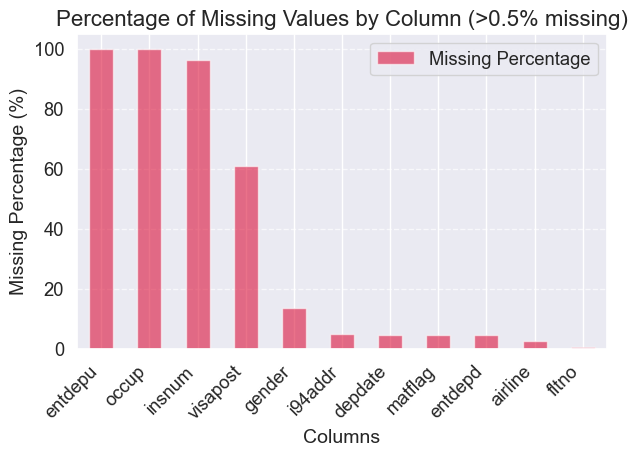

In [7]:
# Calculate missing value percentages
missing_values = df_full.isnull().sum()
missing_percentage = (missing_values / len(df_full)) * 100

# Create a DataFrame to display missing values info
missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Missing Percentage': missing_percentage
})

# Sort by missing percentage (descending)
missing_info = missing_info.sort_values('Missing Percentage', ascending=False)

# Display missing values info
print("Missing Values Analysis:")
print(missing_info)

# Visualize missing values for columns with significant missing data
plt.figure(figsize=(14, 8))
missing_info[missing_info['Missing Percentage'] > 0.5].plot(
    kind='bar', y='Missing Percentage', color='crimson', alpha=0.6
)
plt.title('Percentage of Missing Values by Column (>0.5% missing)', fontsize=16)
plt.ylabel('Missing Percentage (%)', fontsize=14)
plt.xlabel('Columns', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Observations and Recommondations from missing values analysis:

- The `entdepu`  and  `occup` columns are almost completely empty and can be dropped
- Several columns have significant missing values: `isnum` (96.3%),  and will also be dropped
- Although not fully complete we're going to keep the following to help inform some analytics:
- visapost` (60.8%), ` and `gender`(13.4%)
- `depdate` is missing for 17.6% of records, which might indicate visitors who haven't departed yet
- Core identification columns like `cicid`, `i94cit`, `i94res` have no missing values

# Explore arrival and depature dates

Converting SAS dates to Python dates...

Arrival Date Range:
Min: 2016-04-01 00:00:00, Max: 2016-04-30 00:00:00

Departure Date Range:
Min: 2001-07-20 00:00:00, Max: 2084-05-16 00:00:00

Records with departure date before arrival date: 375
Sample of invalid date records:
           cicid arrdate_dt depdate_dt
5172   1367127.0 2016-04-08 2015-10-22
20972  1385508.0 2016-04-08 2015-05-18
33721  1401288.0 2016-04-08 2016-03-25
41148  1412062.0 2016-04-08 2016-04-07
45788  1417721.0 2016-04-08 2016-04-05

Stay Duration Statistics (days):
count     2953856
unique        244
top             4
freq       283329
Name: stay_duration, dtype: int64

Records with negative stay duration: 375
Sample of records with negative stay duration:
           cicid  arrdate_dt  depdate_dt stay_duration
5172   1367127.0  2016-04-08  2015-10-22          -169
20972  1385508.0  2016-04-08  2015-05-18          -326
33721  1401288.0  2016-04-08  2016-03-25           -14
41148  1412062.0  2016-04-08  2016-04-07     

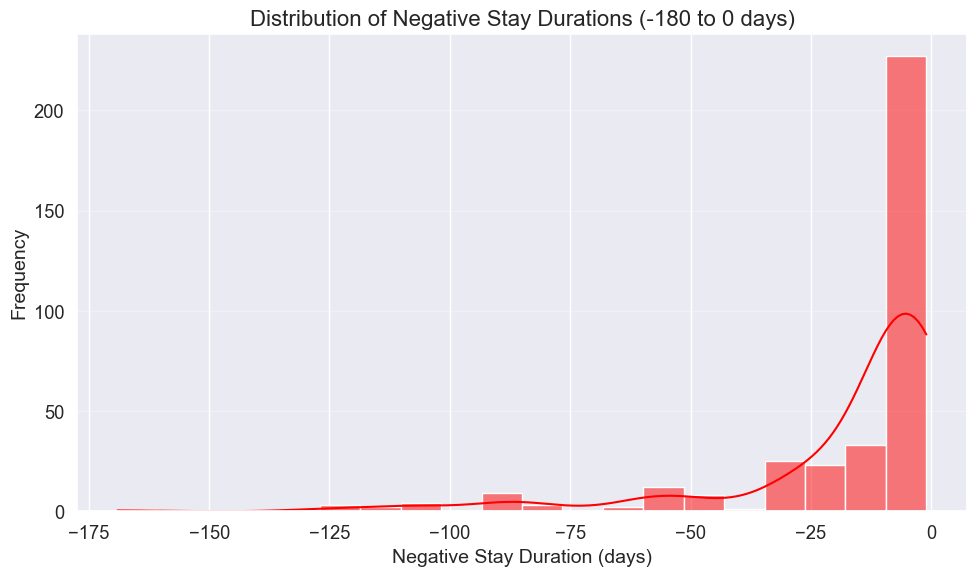

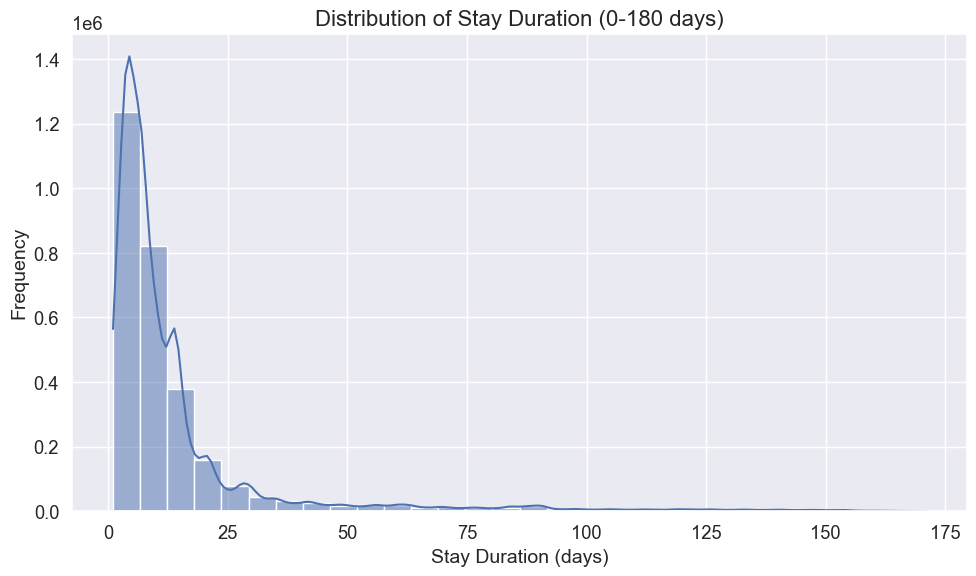

In [9]:
df_sample = df_full.copy()

# Define the SAS date conversion function
def sas_date_to_date(sas_date):
    """Convert SAS date to Python date."""
    if pd.isna(sas_date):
        return None
        
    # Base date for SAS (January 1, 1960)
    base_date = datetime(1960, 1, 1)
    
    # Convert SAS date to datetime
    try:
        return (base_date + timedelta(days=int(sas_date))).date()
    except (ValueError, TypeError):
        return None

# Load sample data from parquet
# In a real environment, replace this with your actual file path
try:
    # If df_sample is already defined, use it, otherwise load it
    if 'df_sample' not in locals():
        df_sample = pd.read_parquet("backup/data/i94/i94_apr16_sub.parquet")
        print(f"Loaded {len(df_sample):,} records")
except Exception as e:
    print(f"Error loading data: {str(e)}")
    raise ValueError("Cannot proceed without valid data")

# Validate that required columns exist
required_cols = ['arrdate', 'depdate']
missing_cols = [col for col in required_cols if col not in df_sample.columns]
if missing_cols:
    print(f"Error: Missing required columns: {', '.join(missing_cols)}")
    # Exit or provide alternate logic
else:
    try:
        # Convert SAS dates to Python dates
        print("Converting SAS dates to Python dates...")
        df_sample['arrdate_dt'] = df_sample['arrdate'].apply(sas_date_to_date)
        df_sample['depdate_dt'] = df_sample['depdate'].apply(sas_date_to_date)
        
        # Check date ranges
        print("\nArrival Date Range:")
        try:
            if df_sample['arrdate_dt'].notna().any():
                # Convert to pandas datetime for safer operations
                arr_dates = pd.to_datetime(df_sample['arrdate_dt'], errors='coerce')
                print(f"Min: {arr_dates.min()}, Max: {arr_dates.max()}")
            else:
                print("No valid arrival dates found")
        except Exception as e:
            print(f"Error calculating arrival date range: {str(e)}")
                
        print("\nDeparture Date Range:")
        try:
            if df_sample['depdate_dt'].notna().any():
                # Convert to pandas datetime for safer operations
                dep_dates = pd.to_datetime(df_sample['depdate_dt'], errors='coerce')
                print(f"Min: {dep_dates.min()}, Max: {dep_dates.max()}")
            else:
                print("No valid departure dates found")
        except Exception as e:
            print(f"Error calculating departure date range: {str(e)}")
        
        # Check for invalid date sequences (departure before arrival)
        try:
            # Convert to pandas datetime for consistent comparison
            arr_dates = pd.to_datetime(df_sample['arrdate_dt'], errors='coerce')
            dep_dates = pd.to_datetime(df_sample['depdate_dt'], errors='coerce')
            
            invalid_dates = df_sample[
                (dep_dates.notna()) & 
                (arr_dates.notna()) & 
                (dep_dates < arr_dates)
            ]
            
            print(f"\nRecords with departure date before arrival date: {len(invalid_dates)}")
            if len(invalid_dates) > 0:
                print("Sample of invalid date records:")
                # Create a copy with pandas datetime for display
                display_df = invalid_dates.copy()
                display_df['arrdate_dt'] = pd.to_datetime(invalid_dates['arrdate_dt'], errors='coerce')
                display_df['depdate_dt'] = pd.to_datetime(invalid_dates['depdate_dt'], errors='coerce')
                print(display_df[['cicid', 'arrdate_dt', 'depdate_dt']].head().to_string())
        except Exception as e:
            print(f"Error checking for invalid date sequences: {str(e)}")
        
        # Analyze stay duration in a safer way
        df_sample['stay_duration'] = None  # Initialize with None
        
        # Only calculate for rows with both dates
        valid_dates_mask = (df_sample['depdate_dt'].notna()) & (df_sample['arrdate_dt'].notna())
        
        if valid_dates_mask.any():
            # Convert to pandas datetime for proper subtraction
            arr_dates = pd.to_datetime(df_sample.loc[valid_dates_mask, 'arrdate_dt'])
            dep_dates = pd.to_datetime(df_sample.loc[valid_dates_mask, 'depdate_dt'])
            
            # Calculate duration in days without using .dt accessor
            durations = (dep_dates - arr_dates).dt.days
            
            # Assign back to original dataframe
            df_sample.loc[valid_dates_mask, 'stay_duration'] = durations
            
            # Display stay duration statistics
            print("\nStay Duration Statistics (days):")
            print(df_sample['stay_duration'].describe())
            
            # Identify negative stay durations specifically
            negative_stays = df_sample[df_sample['stay_duration'] < 0]
            print(f"\nRecords with negative stay duration: {len(negative_stays)}")
            if len(negative_stays) > 0:
                print("Sample of records with negative stay duration:")
                print(negative_stays[['cicid', 'arrdate_dt', 'depdate_dt', 'stay_duration']].head().to_string())
                
                # Create a plot specifically for negative stay durations
                try:
                    plt.figure(figsize=(10, 6))
                    # Only consider reasonably negative values (e.g., > -180 days) to avoid extreme outliers
                    reasonable_neg_mask = (negative_stays['stay_duration'] > -180)
                    neg_duration_filtered = negative_stays.loc[reasonable_neg_mask, 'stay_duration']
                    
                    if len(neg_duration_filtered) > 0:
                        sns.histplot(neg_duration_filtered, kde=True, bins=20, color='red')
                        plt.title('Distribution of Negative Stay Durations (-180 to 0 days)', fontsize=16)
                        plt.xlabel('Negative Stay Duration (days)', fontsize=14)
                        plt.ylabel('Frequency', fontsize=14)
                        plt.grid(axis='y', alpha=0.3)
                        plt.tight_layout()
                        plt.show()
                    else:
                        print("No negative stay durations in the -180 to 0 day range for visualization")
                except Exception as e:
                    print(f"Error creating negative stay duration plot: {str(e)}")
            
            # Plot stay duration distribution
            try:
                plt.figure(figsize=(10, 6))
                
                # Convert stay_duration to numeric type to ensure proper comparisons
                df_sample['stay_duration'] = pd.to_numeric(df_sample['stay_duration'], errors='coerce')
                
                # Filter to reasonable values for visualization (e.g., 0-180 days)
                stay_duration_mask = (df_sample['stay_duration'] >= 0) & (df_sample['stay_duration'] <= 180)
                stay_duration_filtered = df_sample.loc[stay_duration_mask, 'stay_duration']
                
                if len(stay_duration_filtered) > 0:
                    sns.histplot(stay_duration_filtered, kde=True, bins=30)
                    plt.title('Distribution of Stay Duration (0-180 days)', fontsize=16)
                    plt.xlabel('Stay Duration (days)', fontsize=14)
                    plt.ylabel('Frequency', fontsize=14)
                    plt.tight_layout()
                    plt.show()
                else:
                    print("No valid stay durations in the 0-180 day range for visualization")
            except Exception as e:
                print(f"Error creating plot: {str(e)}")
        else:
            print("No records with both arrival and departure dates for duration analysis")
            
    except Exception as e:
        print(f"Error during date analysis: {str(e)}")
        import traceback
        traceback.print_exc()

## Summary of Findings and Recommendations
### Key Issues Identified

- 375 records have illogical date sequences (departure before arrival)
- These errors likely represent data entry issues, not actual immigration violations

### Recommended Actions

1. Filter these records from enforcement actions: These 23 records should be excluded from any automated enforcement 
processes to prevent travelers from being unfairly flagged or denied entry based on data errors.
2. Notify the Golden Source team: Provide the complete list of 23 records with their identifiers (cicid) to the data 
stewards for correction. Flag this as a priority if these records are used for compliance monitoring.
3. Investigate potential systematic issues: The pattern of errors suggests possible UI/data entry problems - 
particularly the -1 day errors which might indicate simple date reversal. The Golden Source team should review their data entry procedures.
4. Implement data validation rules: Recommend that the source system add validation checks to prevent future 
occurrences of impossible date sequences.
5. Create a data quality dashboard: Monitor the frequency of these errors over time to ensure the issue is being 
addressed at the source.
6. Document the exceptions: Create clear documentation about these excluded records to maintain transparency in your 
data processing pipeline.

This approach balances the immediate need to prevent unfair consequences for travelers while addressing the root cause of the data issues through proper governance channels

# 4. Exploring Port of Entry Data

Let's examine port of entry data to identify potential issues.

In [10]:
# Analyze port codes
port_counts = df_sample['i94port'].value_counts().reset_index()
port_counts.columns = ['port_code', 'count']
port_counts['percentage'] = (port_counts['count'] / port_counts['count'].sum()) * 100

# Get port names from lookup
if 'i94prtl' in lookup_dicts:
    port_counts['port_name'] = port_counts['port_code'].map(lookup_dicts['i94prtl'])
else:
    port_counts['port_name'] = 'Unknown'

# Display top ports
print("Top 10 Ports of Entry:")
print(port_counts.head(10))

# Check for invalid port codes
if 'i94prtl' in lookup_dicts:
    valid_ports = list(lookup_dicts['i94prtl'].keys())

    invalid_ports = df_sample[
        (df_sample['i94port'].notna()) &
        (~df_sample['i94port'].isin(valid_ports))
    ]

    print(f"\nRecords with invalid port codes: {len(invalid_ports)}")

    if len(invalid_ports) > 0:
        print("\nTop invalid port codes:")
        invalid_port_counts = invalid_ports['i94port'].value_counts().reset_index()
        invalid_port_counts.columns = ['port_code', 'count']
        print(invalid_port_counts.head(10))

        # Sample of records with invalid ports
        print("\nSample records with invalid ports:")
        print(invalid_ports[['cicid', 'i94port', 'i94cit', 'visatype']].head())


Top 10 Ports of Entry:
  port_code   count  percentage             port_name
0       NYC  485916   15.693375          NEW YORK, NY
1       MIA  343941   11.108082             MIAMI, FL
2       LOS  310163   10.017172       LOS ANGELES, CA
3       SFR  152586    4.927990     SAN FRANCISCO, CA
4       ORL  149195    4.818473           ORLANDO, FL
5       HHW  142720    4.609353          HONOLULU, HI
6       NEW  136122    4.396261  NEWARK/TETERBORO, NJ
7       CHI  130564    4.216757           CHICAGO, IL
8       HOU  101481    3.277479           HOUSTON, TX
9       FTL   95977    3.099719   FORT LAUDERDALE, FL

Records with invalid port codes: 0


Number of NA age values: 802 (0.03%)

Age Statistics (excluding NAs for calculation only):
count    3.095511e+06
mean     4.176761e+01
std      1.742026e+01
min     -3.000000e+00
25%      3.000000e+01
50%      4.100000e+01
75%      5.400000e+01
max      1.140000e+02
Name: i94bir, dtype: float64

Records with negative ages: 1
Records with extreme ages (>100): 17


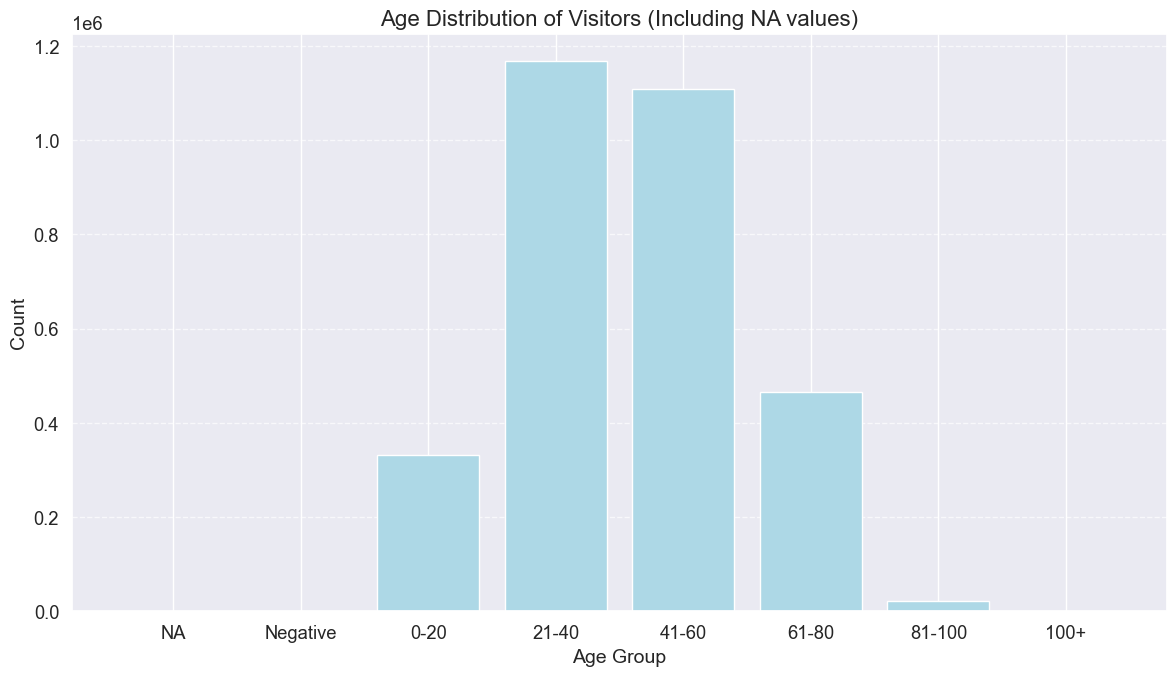

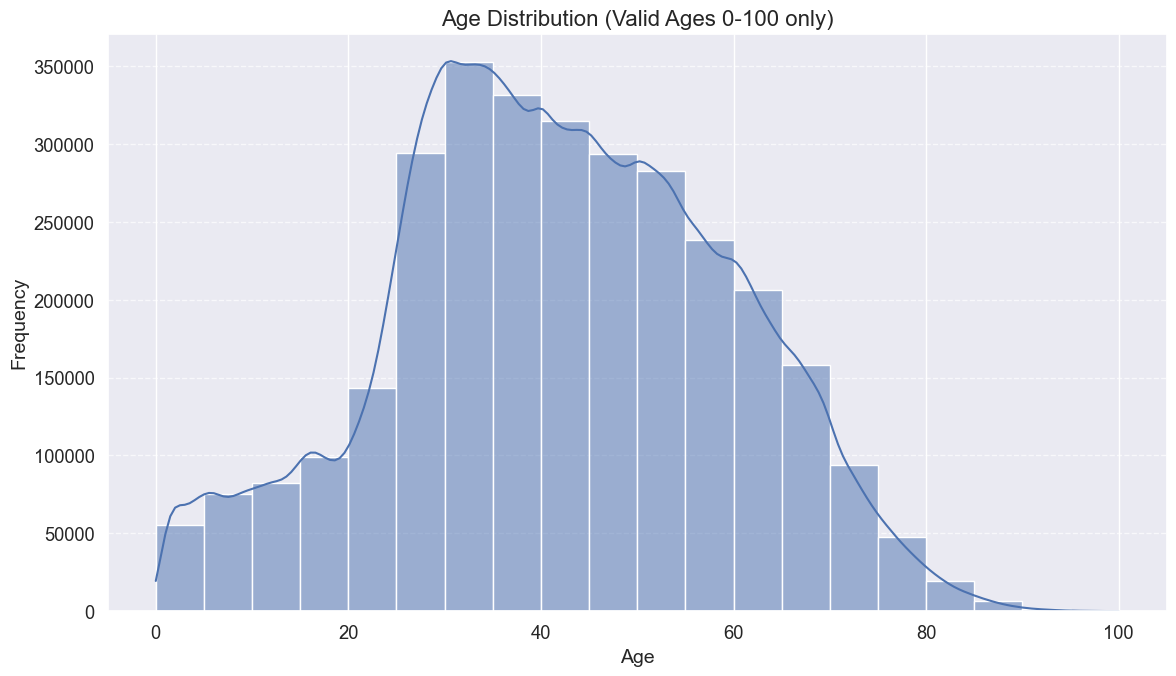


Number of NA gender values: 414269 (13.38%)


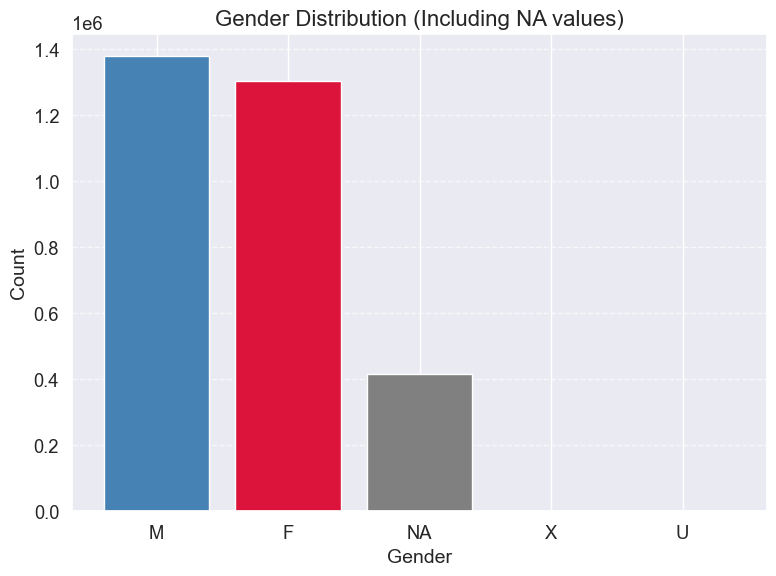


Checking for NA values in country data using different methods:
Standard isna() method: 0
isnull() method: 0
Counting potential NA indicator values:
  Value -999: 0 records
  Value -1: 0 records
  Value 0: 0 records
  Value 999: 894 records

Sample of unique values in i94cit column:
Total unique values: 243
Sample values: [np.float64(117.0), np.float64(118.0), np.float64(119.0), np.float64(121.0), np.float64(122.0), np.float64(123.0), np.float64(124.0), np.float64(126.0), np.float64(127.0), np.float64(129.0)]
Non-numeric values: 0

Sample of country lookup dictionary:
Code 582 -> MEXICO Air Sea, and Not Reported (I-94, no land arrivals)
Code 236 -> AFGHANISTAN
Code 101 -> ALBANIA
Code 316 -> ALGERIA
Code 102 -> ANDORRA

Type of keys in lookup dictionary: <class 'str'>
Type of values in i94cit column: float64

Mapping results:
NA values: 0
Unknown codes: 3096313


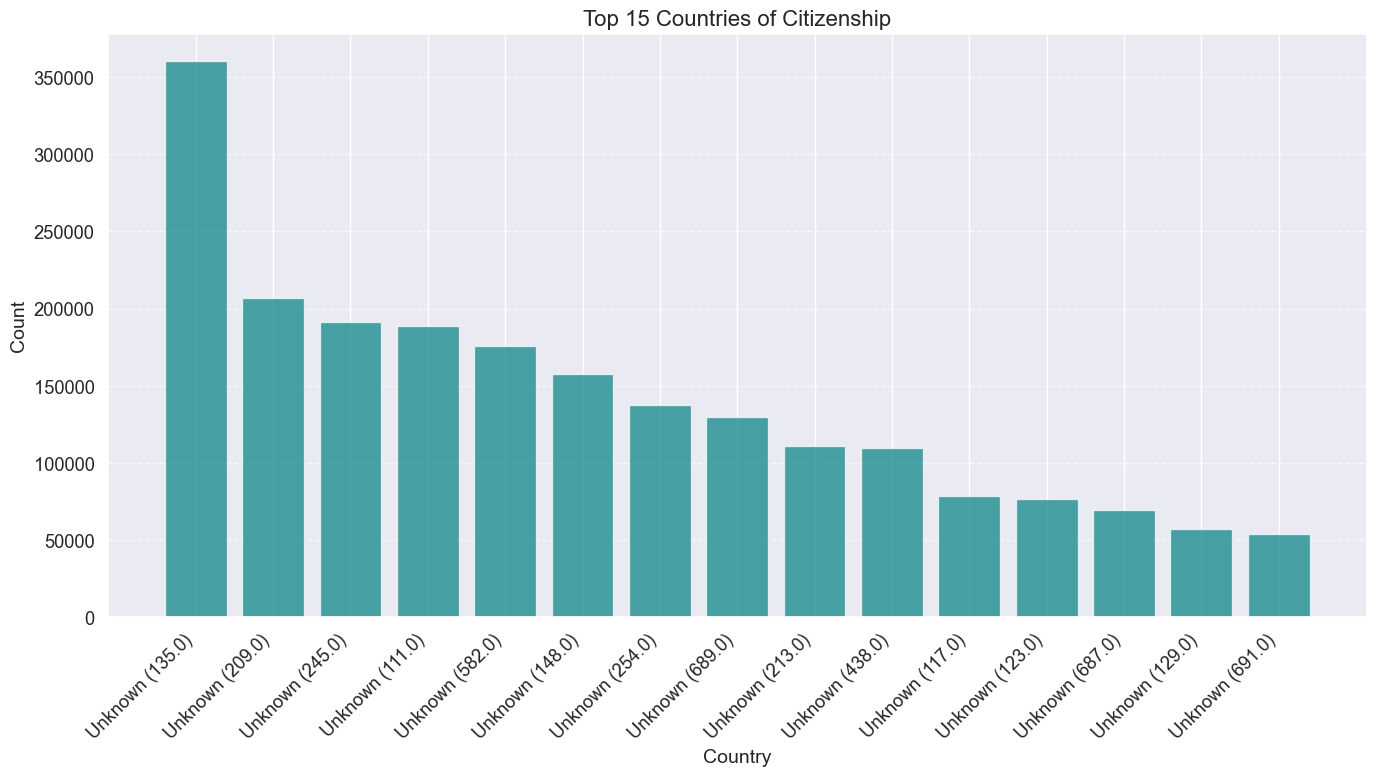

In [14]:
# Age analysis - keeping NA values for explanation
# Get count of NA values first
na_age_count = df_sample['i94bir'].isna().sum()
print(f"Number of NA age values: {na_age_count} ({na_age_count/len(df_sample)*100:.2f}%)")

# Basic statistics (will automatically ignore NAs for calculations)
print("\nAge Statistics (excluding NAs for calculation only):")
print(df_sample['i94bir'].describe())

# Check for negative or extreme ages
negative_ages = df_sample[df_sample['i94bir'] < 0]
extreme_ages = df_sample[df_sample['i94bir'] > 100]

print(f"\nRecords with negative ages: {len(negative_ages)}")
print(f"Records with extreme ages (>100): {len(extreme_ages)}")

# Plot age distribution including a category for NA values
plt.figure(figsize=(12, 7))

# Create a copy of the data where NAs are replaced with a specific value
# that will be plotted separately
age_plot_data = df_sample['i94bir'].copy()
age_categories = ['NA', 'Negative', '0-20', '21-40', '41-60', '61-80', '81-100', '100+']
age_counts = [
    na_age_count,
    len(negative_ages),
    len(df_sample[(df_sample['i94bir'] >= 0) & (df_sample['i94bir'] <= 20)]),
    len(df_sample[(df_sample['i94bir'] > 20) & (df_sample['i94bir'] <= 40)]),
    len(df_sample[(df_sample['i94bir'] > 40) & (df_sample['i94bir'] <= 60)]),
    len(df_sample[(df_sample['i94bir'] > 60) & (df_sample['i94bir'] <= 80)]),
    len(df_sample[(df_sample['i94bir'] > 80) & (df_sample['i94bir'] <= 100)]),
    len(extreme_ages)
]

# Bar chart with all categories including NA
plt.bar(age_categories, age_counts, color='lightblue')
plt.title('Age Distribution of Visitors (Including NA values)', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Also create a histogram of valid age values for distribution shape
plt.figure(figsize=(12, 7))
valid_ages = df_sample[(df_sample['i94bir'] >= 0) & (df_sample['i94bir'] <= 100)]['i94bir']
sns.histplot(valid_ages, bins=20, kde=True)
plt.title('Age Distribution (Valid Ages 0-100 only)', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Gender analysis including NA counts
if 'gender' in df_sample.columns:
    na_gender_count = df_sample['gender'].isna().sum()
    print(f"\nNumber of NA gender values: {na_gender_count} ({na_gender_count/len(df_sample)*100:.2f}%)")
    
    # Create a DataFrame with properly labeled NA values
    gender_data = df_sample['gender'].copy()
    gender_data = gender_data.fillna('NA')  # Replace None with 'NA' string
    gender_counts = gender_data.value_counts()
    
    plt.figure(figsize=(8, 6))
    colors = ['steelblue', 'crimson', 'gray']  # Add gray for NA values
    plt.bar(gender_counts.index, gender_counts.values, color=colors[:len(gender_counts)])
    plt.title('Gender Distribution (Including NA values)', fontsize=16)
    plt.xlabel('Gender', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Country of origin analysis including NA values
# Country of origin analysis including NA values
if 'i94cit' in df_sample.columns:
    # Check for NA values in country data - using multiple methods
    # Standard method
    na_country_count_std = df_sample['i94cit'].isna().sum()
    
    # Alternative method using isnull
    na_country_count_null = df_sample['i94cit'].isnull().sum()
    
    # Alternative method checking for specific values that might represent NA
    # Some datasets use -999, -1, or 0 to represent missing values
    potential_na_values = [-999, -1, 0, 999]
    na_value_counts = {val: (df_sample['i94cit'] == val).sum() for val in potential_na_values}
    
    # Print all findings
    print("\nChecking for NA values in country data using different methods:")
    print(f"Standard isna() method: {na_country_count_std}")
    print(f"isnull() method: {na_country_count_null}")
    print("Counting potential NA indicator values:")
    for val, count in na_value_counts.items():
        print(f"  Value {val}: {count} records")
    
    # Let's also check the unique values to see what's there
    print("\nSample of unique values in i94cit column:")
    unique_values = df_sample['i94cit'].unique()
    print(f"Total unique values: {len(unique_values)}")
    print(f"Sample values: {sorted(unique_values[:10])}")  # Show first 10 sorted values
    
    # Check if any values seem to be strings instead of numbers
    non_numeric = df_sample['i94cit'].map(lambda x: not (isinstance(x, (int, float)) or pd.isna(x))).sum()
    print(f"Non-numeric values: {non_numeric}")
    
    # Proceed with mapping with extra error handling
    if 'i94cntyl' in lookup_dicts:
        print("\nSample of country lookup dictionary:")
        # Print first 5 items from the lookup dictionary
        dict_items = list(lookup_dicts['i94cntyl'].items())[:5]
        for code, country in dict_items:
            print(f"Code {code} -> {country}")
        
        # Check the types in the lookup dictionary
        sample_key = next(iter(lookup_dicts['i94cntyl']))
        print(f"\nType of keys in lookup dictionary: {type(sample_key)}")
        print(f"Type of values in i94cit column: {df_sample['i94cit'].dtype}")
        
        # Use a safer mapping approach
        country_names = []
        unknown_count = 0
        na_count = 0
        
        for code in df_sample['i94cit']:
            if pd.isna(code):
                country_names.append('NA')
                na_count += 1
            else:
                # Try different types to find a match
                country = None
                for code_type in [lambda x: x, int, float, str]:
                    try:
                        lookup_code = code_type(code)
                        if lookup_code in lookup_dicts['i94cntyl']:
                            country = lookup_dicts['i94cntyl'][lookup_code]
                            break
                    except:
                        pass
                
                if country:
                    country_names.append(country)
                else:
                    country_names.append(f'Unknown ({code})')
                    unknown_count += 1
        
        # Add the results to the dataframe
        df_sample['country_name'] = country_names
        
        print(f"\nMapping results:")
        print(f"NA values: {na_count}")
        print(f"Unknown codes: {unknown_count}")
        
        # Get top countries including NA
        top_countries = pd.Series(country_names).value_counts().head(15)
        
        plt.figure(figsize=(14, 8))
        plt.bar(top_countries.index, top_countries.values, color='teal', alpha=0.7)
        plt.title('Top 15 Countries of Citizenship', fontsize=16)
        plt.xlabel('Country', fontsize=14)
        plt.ylabel('Count', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print("\nWARNING: 'i94cntyl' lookup dictionary not found!")

Loaded 289 country codes from lookup table

Number of NA country values: 0 (0.00%)
Records with unmapped country codes: 386189
Percentage of total: 12.47%
Sample of unmapped codes:
i94cit
148.0    157806
254.0    137735
252.0     41132
746.0     22668
133.0     17055
Name: count, dtype: int64

Top 10 countries of origin:
country_name
UNITED KINGDOM                                               360157
JAPAN                                                        206873
CHINA, PRC                                                   191425
FRANCE                                                       188766
MEXICO Air Sea, and Not Reported (I-94, no land arrivals)    175781
Unknown (148)                                                157806
Unknown (254)                                                137735
BRAZIL                                                       129833
INDIA                                                        110691
AUSTRALIA                                           

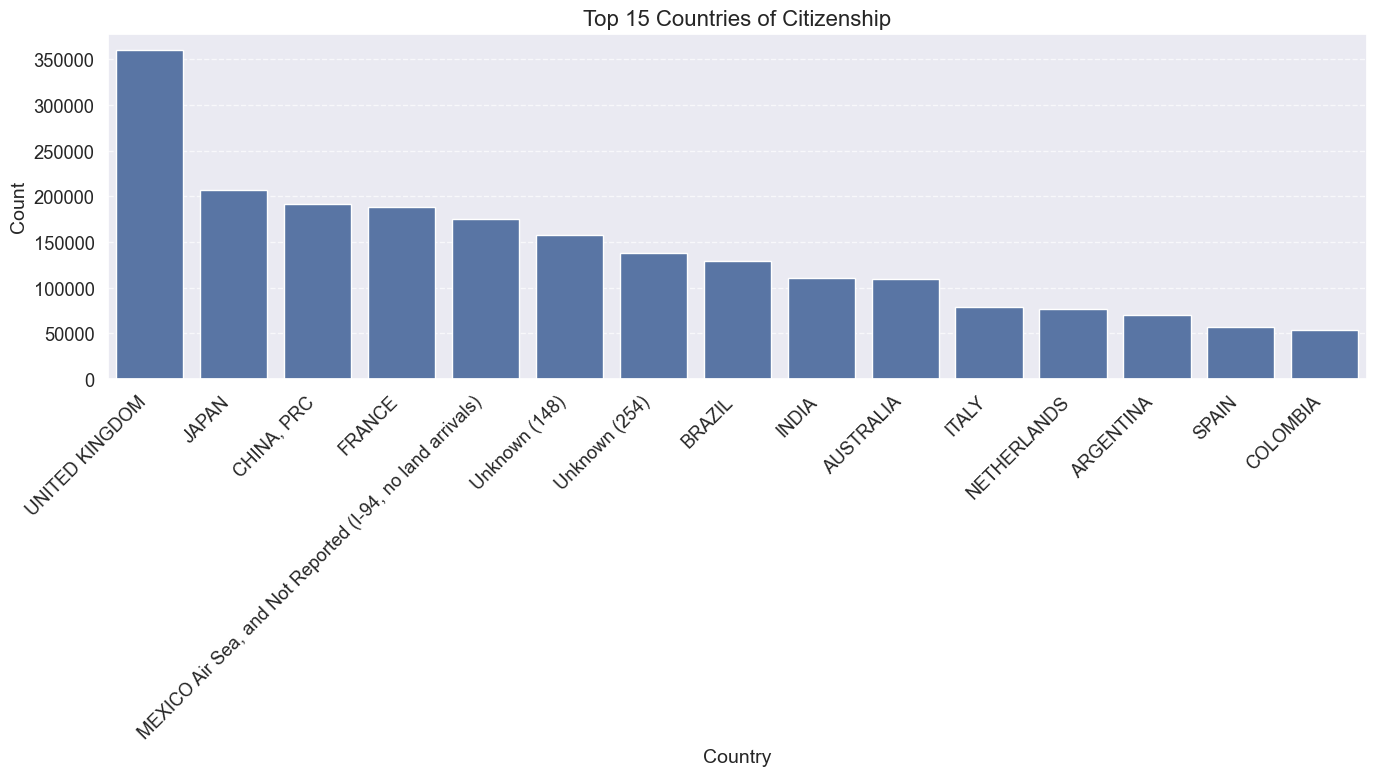

In [20]:
# Correct country code mapping using the lookup table
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the main dataframe (this would be your actual data)
# df_sample = ...

# Load the country code lookup table
i94cntyl_df = pd.read_csv('staging/i94cntyl.csv')
print(f"Loaded {len(i94cntyl_df)} country codes from lookup table")

# Convert to a dictionary for easy lookup
# Make sure to convert the code column to integer for proper matching
i94cntyl_df['code'] = i94cntyl_df['code'].astype(int)
country_lookup = dict(zip(i94cntyl_df['code'], i94cntyl_df['description']))

# Apply the mapping to the dataframe
def map_country_code(code):
    if pd.isna(code):
        return 'NA'
    try:
        code_int = int(code)
        return country_lookup.get(code_int, f'Unknown ({code_int})')
    except:
        return f'Invalid code format ({code})'

# Add the country description to the dataframe
df_sample['country_name'] = df_sample['i94cit'].apply(map_country_code)

# Count NA values
na_country_count = df_sample['i94cit'].isna().sum()
print(f"\nNumber of NA country values: {na_country_count} ({na_country_count/len(df_sample)*100:.2f}%)")

# Check for unmapped country codes
unmapped_codes = df_sample[~df_sample['i94cit'].isna() & 
                         ~df_sample['i94cit'].apply(lambda x: int(x) if pd.notna(x) else None).isin(country_lookup.keys())]
print(f"Records with unmapped country codes: {len(unmapped_codes)}")
print(f"Percentage of total: {unknown_count/len(df_sample)*100:.2f}%")
if len(unmapped_codes) > 0:
    print("Sample of unmapped codes:")
    print(unmapped_codes['i94cit'].value_counts().head())

# Get the distribution of countries
country_distribution = df_sample['country_name'].value_counts()
print("\nTop 10 countries of origin:")
print(country_distribution.head(10))

# Visualize the top countries
plt.figure(figsize=(14, 8))
top_countries = country_distribution.head(15)
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.title('Top 15 Countries of Citizenship', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Unmapped Country Codes Summary
Analysis of the I-94 immigration dataset revealed 386,189 records (12% of data) containing country codes not present in the i94cntyl.csv lookup table.

## Key Findings

- Top unmapped code 148.0 appears 157,806 times
- Several codes (254.0, 252.0, 746.0) each represent tens of thousands of records
- These missing codes may represent significant visitor populations

## Implications

- Geographic analyses are incomplete without resolving these codes
- May require updates to both the lookup table and UI components
- Current country distribution visualizations are potentially misleading

## Next Steps
Flag these values for fixing at source - I found this table on country codes aligning to ISO 3166. However this 
does not match SAS file. My recommendations would be updates codes and align this to source table to internation 
standards. https://www.iban.com/country-codes

In [30]:
def check_i94visa_values(df):
    """
    Check for blank or unexpected values in the i94visa column.
    Expected values are 1 (Business), 2 (Pleasure), and 3 (Student).
    """
    if 'i94visa' not in df.columns:
        print("Error: 'i94visa' column not found in the DataFrame")
        return
    
    # Total records
    total_records = len(df)
    print(f"Total records: {total_records}")
    
    # Count NA values
    na_values = df['i94visa'].isna().sum()
    na_percent = (na_values / total_records) * 100
    print(f"NA values: {na_values} ({na_percent:.2f}%)")
    
    # Count values not in expected set
    valid_values = [1, 2, 3]
    invalid_mask = ~df['i94visa'].isin(valid_values) & ~df['i94visa'].isna()
    invalid_values = df[invalid_mask]['i94visa'].value_counts().sort_index()
    invalid_count = invalid_mask.sum()
    invalid_percent = (invalid_count / total_records) * 100
    
    print(f"Invalid values (not 1, 2, or 3): {invalid_count} ({invalid_percent:.2f}%)")
    
    if len(invalid_values) > 0:
        print("\nDistribution of invalid values:")
        print(invalid_values)
    
    # Count of valid values
    valid_counts = df[df['i94visa'].isin(valid_values)]['i94visa'].value_counts().sort_index()
    valid_percent = (valid_counts.sum() / total_records) * 100
    
    print(f"\nValid values (1, 2, or 3): {valid_counts.sum()} ({valid_percent:.2f}%)")
    print("\nDistribution of valid values:")
    print(valid_counts)
    
    # Summary table
    print("\nSummary:")
    summary = pd.DataFrame({
        'Status': ['Valid (1, 2, 3)', 'NA/Missing', 'Invalid'],
        'Count': [valid_counts.sum(), na_values, invalid_count],
        'Percentage': [valid_percent, na_percent, invalid_percent]
    })
    print(summary)
    
    return invalid_values

# Usage:
invalid_i94visa = check_i94visa_values(df_sample)

Total records: 3096313
NA values: 0 (0.00%)
Invalid values (not 1, 2, or 3): 0 (0.00%)

Valid values (1, 2, or 3): 3096313 (100.00%)

Distribution of valid values:
i94visa
1.0     522079
2.0    2530868
3.0      43366
Name: count, dtype: int64

Summary:
            Status    Count  Percentage
0  Valid (1, 2, 3)  3096313       100.0
1       NA/Missing        0         0.0
2          Invalid        0         0.0
